# Milestone 2

## i. Perkenalan

Nama: Ferrasta Sebastian Veron

Batch: RMT 030

Objective: Membuat model supervised learning untuk memprediksi rating suatu Board Game menggunakan fitur-fitur yang tersedia.

Board Game sendiri biasanya adalah permainan yang dimainkan di atas papan atau meja. 

Dataset ini berisikan rating dari banyak board game yang didapatkan dari website BoardGameGeek (BGG). Berikut ini adalah deskripsi dari masing-masing kolom dalam dataset:

- ID: id di website BGG

- Name: Nama dari board game

- Year Published: Tahun board game tersebut rilis

- Min Players: Jumlah pemain minimum yang direkomendasikan

- Max Players: Jumlah pemain maksimal yang direkomendasikan

- Play Time: Rata-rata waktu permainan yang direkomendasikan pembuat gamenya

- Min Age: Umur minimal pemain

- Users Rated: Jumlah pemain yang memberi rating pada gamenya

- Rating Average: Rata-rata rating atau nilai dari game

- BGG Rank: Ranking di website BGG

- Complexity Average: Rata-rata tingkat kesulitan permainan

- Owned Users: Jumlah user BGG yang memiliki game tersebut

- Mechanics: Cara bermain gamenya

- Domains: Subgenre dari game tersebut

## ii. Import Libraries

In [117]:
# !pip install feature_engine

In [118]:
# import libraries yang dibutuhkan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pickle
import json
import time
import xgboost as xgb
from matplotlib import colors
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler,
from sklearn.linear_model import LinearRegression
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

## iii. Data Loading

In [119]:
# memanggil file csv ke dalam dataset
df = pd.read_csv('bgg_dataset.csv', sep=';')
df

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,"8,61",2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,"8,66",3,"3,91",28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,"8,43",4,"3,24",87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,"8,70",5,"4,22",16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,16398.0,War,0.0,2,2,30,4,1340,"2,28",20340,1,427.0,NaN,Children's Games
20339,7316.0,Bingo,1530.0,2,99,60,5,2154,"2,85",20341,"1,05",1533.0,"Betting and Bluffing, Bingo, Pattern Recognition",Party Games
20340,5048.0,Candy Land,1949.0,2,4,30,3,4006,"3,18",20342,"1,08",5788.0,Roll / Spin and Move,Children's Games
20341,5432.0,Chutes and Ladders,-200.0,2,6,30,3,3783,"2,86",20343,"1,02",4400.0,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games


In [120]:
# menampilkan info singkat dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  20327 non-null  float64
 1   Name                20343 non-null  object 
 2   Year Published      20342 non-null  float64
 3   Min Players         20343 non-null  int64  
 4   Max Players         20343 non-null  int64  
 5   Play Time           20343 non-null  int64  
 6   Min Age             20343 non-null  int64  
 7   Users Rated         20343 non-null  int64  
 8   Rating Average      20343 non-null  object 
 9   BGG Rank            20343 non-null  int64  
 10  Complexity Average  20343 non-null  object 
 11  Owned Users         20320 non-null  float64
 12  Mechanics           18745 non-null  object 
 13  Domains             10184 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 2.2+ MB


In [121]:
# mengubah nama kolom agar lebih mudah diketik ketika proses pemodelan
df.rename(columns = {'ID':'id',
                     'Name': 'name',
                     'Year Published': 'year',
                     'Min Players': 'min_players',
                     'Max Players': 'max_players',
                     'Play Time': 'playtime',
                     'Min Age': 'min_age',
                     'Users Rated': 'users_rated',
                     'Rating Average': 'rating',
                     'BGG Rank': 'rank',
                     'Complexity Average': 'complexity',
                     'Owned Users': 'owned_users',
                     'Mechanics': 'mechanics',
                     'Domains': 'domains'
                      }, inplace = True )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           20327 non-null  float64
 1   name         20343 non-null  object 
 2   year         20342 non-null  float64
 3   min_players  20343 non-null  int64  
 4   max_players  20343 non-null  int64  
 5   playtime     20343 non-null  int64  
 6   min_age      20343 non-null  int64  
 7   users_rated  20343 non-null  int64  
 8   rating       20343 non-null  object 
 9   rank         20343 non-null  int64  
 10  complexity   20343 non-null  object 
 11  owned_users  20320 non-null  float64
 12  mechanics    18745 non-null  object 
 13  domains      10184 non-null  object 
dtypes: float64(3), int64(6), object(5)
memory usage: 2.2+ MB


In [122]:
# mencari jumlah nilai null tiap kolom
df.isna().sum()

id                16
name               0
year               1
min_players        0
max_players        0
playtime           0
min_age            0
users_rated        0
rating             0
rank               0
complexity         0
owned_users       23
mechanics       1598
domains        10159
dtype: int64

Karena jumlahnya hanya 1 di kolom year maka saya putuskan untuk mendrop nilai kosong tersebut.

In [123]:
# drop kolom null pada year
df.dropna(subset = ['year'], inplace = True)
df.year = df.year.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20342 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           20327 non-null  float64
 1   name         20342 non-null  object 
 2   year         20342 non-null  int32  
 3   min_players  20342 non-null  int64  
 4   max_players  20342 non-null  int64  
 5   playtime     20342 non-null  int64  
 6   min_age      20342 non-null  int64  
 7   users_rated  20342 non-null  int64  
 8   rating       20342 non-null  object 
 9   rank         20342 non-null  int64  
 10  complexity   20342 non-null  object 
 11  owned_users  20320 non-null  float64
 12  mechanics    18745 non-null  object 
 13  domains      10184 non-null  object 
dtypes: float64(2), int32(1), int64(6), object(5)
memory usage: 2.3+ MB


Terlihat kolom rating dan complexity yang harusnya bentuknya float dan dipisah oleh decimal, malah berbentuk string dan dipisah oleh koma.

In [124]:
# dua baris teratas dataset 
df.head(2)

,id,name,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,mechanics,domains
0,174430.0,Gloomhaven,2017,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015,2,4,60,13,41643,"8,61",2,"2,84",65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"


Ganti separator nilai kedua kolom tersebut dan ubah tipe data ke float.

In [125]:
# mengubah tipe data dan separator untuk kolom rating dan complexity
df.rating = df.rating.str.replace(',', '.').astype(float)
df.complexity = df.complexity.str.replace(',', '.').astype(float)

df.head(2)

,id,name,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,mechanics,domains
0,174430.0,Gloomhaven,2017,1,4,120,14,42055,8.79,1,3.86,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015,2,4,60,13,41643,8.61,2,2.84,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"


Karena jumlah nilai null di owned_users juga tidak signifikan, maka di drop juga.

In [126]:
# drop null values di kolom owned_users dan ubah tipe data ke integer
df.dropna(subset = ['owned_users'], inplace = True)
df.owned_users = df.owned_users.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20320 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           20320 non-null  float64
 1   name         20320 non-null  object 
 2   year         20320 non-null  int32  
 3   min_players  20320 non-null  int64  
 4   max_players  20320 non-null  int64  
 5   playtime     20320 non-null  int64  
 6   min_age      20320 non-null  int64  
 7   users_rated  20320 non-null  int64  
 8   rating       20320 non-null  float64
 9   rank         20320 non-null  int64  
 10  complexity   20320 non-null  float64
 11  owned_users  20320 non-null  int32  
 12  mechanics    18739 non-null  object 
 13  domains      10184 non-null  object 
dtypes: float64(3), int32(2), int64(6), object(3)
memory usage: 2.2+ MB


In [127]:
# 10 baris teratas
df.head(10)

,id,name,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,mechanics,domains
0,174430.0,Gloomhaven,2017,1,4,120,14,42055,8.79,1,3.86,68323,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015,2,4,60,13,41643,8.61,2,2.84,65294,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018,2,4,120,14,19217,8.66,3,3.91,28785,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016,1,5,120,12,64864,8.43,4,3.24,87099,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017,3,6,480,14,13468,8.70,5,4.22,16831,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"
5,291457.0,Gloomhaven: Jaws of the Lion,2020,1,4,120,14,8392,8.87,6,3.55,21609,"Action Queue, Campaign / Battle Card Driven, C...","Strategy Games, Thematic Games"
6,182028.0,Through the Ages: A New Story of Civilization,2015,2,4,120,14,23061,8.43,7,4.41,26985,"Action Points, Auction/Bidding, Auction: Dutch...",Strategy Games
7,220308.0,Gaia Project,2017,1,4,150,12,16352,8.49,8,4.35,20312,"End Game Bonuses, Hexagon Grid, Income, Modula...",Strategy Games
8,187645.0,Star Wars: Rebellion,2016,2,4,240,14,23081,8.42,9,3.71,34849,"Area Majority / Influence, Area Movement, Area...",Thematic Games
9,12333.0,Twilight Struggle,2005,2,2,180,13,40814,8.29,10,3.59,56219,"Action/Event, Advantage Token, Area Majority /...","Strategy Games, Wargames"


In [128]:
# cek nilai kosong di kolom mechanics
df.mechanics.isna().sum()

1581

Terdapat nilai kosong sebanyak 1581 pada kolom mechanics, nilainya sekitar 7,78 % dari total keseluruhan data. Nilai tersebut lebih dari 5% sehingga sulit untuk langsung di drop. Saya memutuskan untuk mengisi mechanics yang kosong dengan "Not Specified".

In [129]:
# mengisi nilai null
df.mechanics = df.mechanics.fillna('Not Specified')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20320 entries, 0 to 20342
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           20320 non-null  float64
 1   name         20320 non-null  object 
 2   year         20320 non-null  int32  
 3   min_players  20320 non-null  int64  
 4   max_players  20320 non-null  int64  
 5   playtime     20320 non-null  int64  
 6   min_age      20320 non-null  int64  
 7   users_rated  20320 non-null  int64  
 8   rating       20320 non-null  float64
 9   rank         20320 non-null  int64  
 10  complexity   20320 non-null  float64
 11  owned_users  20320 non-null  int32  
 12  mechanics    20320 non-null  object 
 13  domains      10184 non-null  object 
dtypes: float64(3), int32(2), int64(6), object(3)
memory usage: 2.2+ MB


In [130]:
# memisahkan nilai dalam kolom "Mechanics" menjadi daftar terpisah
mechanics_split = df.mechanics.str.split(', ')

# gabungkan semua daftar menjadi satu daftar
all_mechanics = [mechanic for sublist in mechanics_split for mechanic in sublist]

# hitung frekuensi kemunculan masing-masing mekanik
mechanics_counts = pd.Series(all_mechanics).value_counts()

# tampilkan mekanik teratas
top_mechanics = mechanics_counts.head(8)
print(top_mechanics)

Dice Rolling              5671
Hand Management           4149
Set Collection            2730
Variable Player Powers    2533
Hexagon Grid              2252
Simulation                1943
Card Drafting             1730
Tile Placement            1692
Name: count, dtype: int64


In [131]:
# jumlah mekanik dalam data
unique_mechanics = pd.Series(all_mechanics).nunique()
unique_mechanics

183

Ada 183 jenis mekanik dalam dunia board game. Untuk mengurangi jumlah mekanik agar hanya satu mekanik per game, maka saya akan mengambil mekanik pertama saja sebagai Top Mechanics.

In [132]:
# membuat kolom baru top mechanics dari mechanics
df['top_mechanics'] = df.mechanics.str.split(', ').str[0]

In [133]:
# tampilkan hasilnya
df

,id,name,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,mechanics,domains,top_mechanics
0,174430.0,Gloomhaven,2017,1,4,120,14,42055,8.79,1,3.86,68323,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games",Action Queue
1,161936.0,Pandemic Legacy: Season 1,2015,2,4,60,13,41643,8.61,2,2.84,65294,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games",Action Points
2,224517.0,Brass: Birmingham,2018,2,4,120,14,19217,8.66,3,3.91,28785,"Hand Management, Income, Loans, Market, Networ...",Strategy Games,Hand Management
3,167791.0,Terraforming Mars,2016,1,5,120,12,64864,8.43,4,3.24,87099,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games,Card Drafting
4,233078.0,Twilight Imperium: Fourth Edition,2017,3,6,480,14,13468,8.70,5,4.22,16831,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games",Action Drafting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,16398.0,War,0,2,2,30,4,1340,2.28,20340,1.00,427,Not Specified,Children's Games,Not Specified
20339,7316.0,Bingo,1530,2,99,60,5,2154,2.85,20341,1.05,1533,"Betting and Bluffing, Bingo, Pattern Recognition",Party Games,Betting and Bluffing
20340,5048.0,Candy Land,1949,2,4,30,3,4006,3.18,20342,1.08,5788,Roll / Spin and Move,Children's Games,Roll / Spin and Move
20341,5432.0,Chutes and Ladders,-200,2,6,30,3,3783,2.86,20343,1.02,4400,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games,Dice Rolling


In [134]:
# cek nilai kosong di kolom domains
df.domains.isna().sum()

10136

Karena jumlahnya juga sangat signifikan, maka nilai null tersebut akan saya isi dengan Not Specified.

In [135]:
# mengisi nilai null
df.domains = df.domains.fillna('Not Specified')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20320 entries, 0 to 20342
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20320 non-null  float64
 1   name           20320 non-null  object 
 2   year           20320 non-null  int32  
 3   min_players    20320 non-null  int64  
 4   max_players    20320 non-null  int64  
 5   playtime       20320 non-null  int64  
 6   min_age        20320 non-null  int64  
 7   users_rated    20320 non-null  int64  
 8   rating         20320 non-null  float64
 9   rank           20320 non-null  int64  
 10  complexity     20320 non-null  float64
 11  owned_users    20320 non-null  int32  
 12  mechanics      20320 non-null  object 
 13  domains        20320 non-null  object 
 14  top_mechanics  20320 non-null  object 
dtypes: float64(3), int32(2), int64(6), object(4)
memory usage: 2.3+ MB


In [136]:
# membuat kolom baru top domains dari domains
df['top_domains'] = df.domains.str.split(', ').str[0]
df

,id,name,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,mechanics,domains,top_mechanics,top_domains
0,174430.0,Gloomhaven,2017,1,4,120,14,42055,8.79,1,3.86,68323,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games",Action Queue,Strategy Games
1,161936.0,Pandemic Legacy: Season 1,2015,2,4,60,13,41643,8.61,2,2.84,65294,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games",Action Points,Strategy Games
2,224517.0,Brass: Birmingham,2018,2,4,120,14,19217,8.66,3,3.91,28785,"Hand Management, Income, Loans, Market, Networ...",Strategy Games,Hand Management,Strategy Games
3,167791.0,Terraforming Mars,2016,1,5,120,12,64864,8.43,4,3.24,87099,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games,Card Drafting,Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017,3,6,480,14,13468,8.70,5,4.22,16831,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games",Action Drafting,Strategy Games
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20338,16398.0,War,0,2,2,30,4,1340,2.28,20340,1.00,427,Not Specified,Children's Games,Not Specified,Children's Games
20339,7316.0,Bingo,1530,2,99,60,5,2154,2.85,20341,1.05,1533,"Betting and Bluffing, Bingo, Pattern Recognition",Party Games,Betting and Bluffing,Party Games
20340,5048.0,Candy Land,1949,2,4,30,3,4006,3.18,20342,1.08,5788,Roll / Spin and Move,Children's Games,Roll / Spin and Move,Children's Games
20341,5432.0,Chutes and Ladders,-200,2,6,30,3,3783,2.86,20343,1.02,4400,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games,Dice Rolling,Children's Games


In [137]:
# menghitung jumlah domain yang ada dalam data
df.top_domains.value_counts()

top_domains
Not Specified         10136
Wargames               3029
Family Games           1950
Strategy Games         1776
Abstract Games         1070
Children's Games        825
Thematic Games          786
Party Games             453
Customizable Games      295
Name: count, dtype: int64

In [138]:
# hasil akhir data setelah diproses
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20320 entries, 0 to 20342
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20320 non-null  float64
 1   name           20320 non-null  object 
 2   year           20320 non-null  int32  
 3   min_players    20320 non-null  int64  
 4   max_players    20320 non-null  int64  
 5   playtime       20320 non-null  int64  
 6   min_age        20320 non-null  int64  
 7   users_rated    20320 non-null  int64  
 8   rating         20320 non-null  float64
 9   rank           20320 non-null  int64  
 10  complexity     20320 non-null  float64
 11  owned_users    20320 non-null  int32  
 12  mechanics      20320 non-null  object 
 13  domains        20320 non-null  object 
 14  top_mechanics  20320 non-null  object 
 15  top_domains    20320 non-null  object 
dtypes: float64(3), int32(2), int64(6), object(5)
memory usage: 2.5+ MB


## iv. EDA

In [139]:
# copy data agar tidak mengubah data asli
df2 = df.copy()

In [140]:
# kolom baru bernama game age
# hasil pengurangan tahun 2024 dengan kolom tahun pada data
df2['game_age'] = 2024 - df2['year']
df2.head(2)

,id,name,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,mechanics,domains,top_mechanics,top_domains,game_age
0,174430.0,Gloomhaven,2017,1,4,120,14,42055,8.79,1,3.86,68323,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games",Action Queue,Strategy Games,7
1,161936.0,Pandemic Legacy: Season 1,2015,2,4,60,13,41643,8.61,2,2.84,65294,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games",Action Points,Strategy Games,9


In [141]:
# mengurutkan data berdasarkan kolom rating dan menunjukkan baris teratas
sort_rating = df2.sort_values(by='rating', ascending=False)
sort_rating.head()

,id,name,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,mechanics,domains,top_mechanics,top_domains,game_age
14596,275777.0,Erune,0,2,5,120,12,31,9.58,14598,0.00,10,"Action Points, Dice Rolling, Modular Board, Pa...",Not Specified,Action Points,Not Specified,2024
11687,322354.0,DEFCON 1,2021,2,5,180,14,57,9.54,11689,3.00,12,Variable Player Powers,Not Specified,Variable Player Powers,Not Specified,3
10246,275972.0,Star Trek: Alliance - Dominion War Campaign,2021,1,2,30,14,54,9.46,10248,3.29,117,Cooperative Game,Not Specified,Cooperative Game,Not Specified,3
13547,281257.0,Aeolis,2020,1,7,120,18,37,9.43,13549,2.00,15,"Area Majority / Influence, Campaign / Battle C...",Not Specified,Area Majority / Influence,Not Specified,4
16310,228370.0,TerroriXico,2017,2,4,30,10,70,9.43,16312,2.50,35,"Area Majority / Influence, Cooperative Game, D...",Not Specified,Area Majority / Influence,Not Specified,7


In [142]:
# mengurutkan data berdasarkan kolom rating dan menunjukkan baris terbawah
sort_rating = df2.sort_values(by='rating', ascending=False)
sort_rating.tail()

,id,name,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,mechanics,domains,top_mechanics,top_domains,game_age
20088,18044.0,BreaKey,2003,2,2,1,0,46,1.50,20090,1.0,16,Variable Player Powers,Not Specified,Variable Player Powers,Not Specified,21
20068,99918.0,W.W.B,2011,2,2,0,0,41,1.43,20070,3.0,3,"Dice Rolling, Roll / Spin and Move","Abstract Games, Thematic Games",Dice Rolling,Abstract Games,13
19957,19377.0,Rock Paper Scissors Game,2005,2,4,5,6,30,1.32,19959,1.0,10,Rock-Paper-Scissors,Not Specified,Rock-Paper-Scissors,Not Specified,19
20286,276022.0,Alien: USCSS Nostromo,2019,2,7,40,14,263,1.10,20288,1.0,12,Not Specified,Not Specified,Not Specified,Not Specified,5
20203,144110.0,Oneupmanship: Mine's Bigger,2013,2,4,90,12,67,1.05,20205,1.0,6,"Auction/Bidding, Dice Rolling, Player Eliminat...",Not Specified,Auction/Bidding,Not Specified,11


- Board Game dengan rating terbaik menurut dataset dari BoardGameGeek adalah Erune dengan rating hampir sempurna di 9.58. Meski game tersebut hanya memiliki maksimal pemain 5 orang, tapi waktu rata-rata untuk memainkannya berkisar di 2 jam. 

- Sedangkan untuk Board Game dengan rating terburuk dipegang oleh Oneupmanship yang rilis tahun 2013. Game tersebut hanya memiliki rating 1.05 dari total 67 orang pemain yang memberi rating. Mekanik utama dari game tersebut adalah Auction atau lelang.

In [143]:
# deskripsi dari kolom numerik
df2.describe()

,id,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,game_age
count,20320.000000,20320.000000,20320.000000,20320.000000,20320.000000,20320.000000,20320.000000,20320.000000,20320.000000,20320.000000,20320.000000,20320.000000
mean,108210.740748,1984.226230,2.019636,5.673327,91.326772,9.600246,841.778691,6.403363,10170.563976,1.990994,1408.457628,39.773770
std,98678.347583,214.117399,0.690545,15.239657,545.749554,3.645790,3513.464339,0.935762,5873.389392,0.849022,5040.179315,214.117399
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,30.000000,1.050000,1.000000,0.000000,0.000000,2.000000
25%,11035.250000,2001.000000,2.000000,4.000000,30.000000,8.000000,55.000000,5.820000,5084.750000,1.330000,146.000000,8.000000
50%,88928.000000,2011.000000,2.000000,4.000000,45.000000,10.000000,120.000000,6.430000,10168.500000,1.970000,309.000000,13.000000
75%,192924.750000,2016.000000,2.000000,6.000000,90.000000,12.000000,385.000000,7.030000,15258.250000,2.540000,864.000000,23.000000
max,331787.000000,2022.000000,10.000000,999.000000,60000.000000,25.000000,102214.000000,9.580000,20344.000000,5.000000,155312.000000,5524.000000


In [144]:
# mencari board game tertua
oldest_board_game = df2.loc[df2['year'] == -3500]
oldest_board_game

,id,name,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,mechanics,domains,top_mechanics,top_domains,game_age
8174,2399.0,Senet,-3500,2,2,30,6,664,5.82,8176,1.48,1343,"Dice Rolling, Roll / Spin and Move",Abstract Games,Dice Rolling,Abstract Games,5524


In [145]:
# mencari board game terbaru
newest_board_game = df2.loc[df2['year'] == 2022]
newest_board_game

,id,name,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,mechanics,domains,top_mechanics,top_domains,game_age
8978,286063.0,The 7th Citadel,2022,1,4,1000,14,44,8.27,8980,2.0,383,"Cooperative Game, Grid Movement, Hand Manageme...",Not Specified,Cooperative Game,Not Specified,2


In [146]:
# mencari board game dengan waktu permainan terlama
playtime = df2.loc[df2['playtime'] == 60000]
playtime

,id,name,year,min_players,max_players,playtime,min_age,users_rated,rating,rank,complexity,owned_users,mechanics,domains,top_mechanics,top_domains,game_age
13420,4815.0,The Campaign for North Africa: The Desert War ...,1979,8,10,60000,14,146,6.1,13422,4.71,385,"Dice Rolling, Hexagon Grid, Simulation",Wargames,Dice Rolling,Wargames,45



- Board Game tertua dalam dataset berumur sekitar 5500 tahun dan pertama kali dirilis sekitar tahun 3500 sebelum masehi. Nama game tersebut adalah Senet yang berasal dari zaman Mesir kuno. Permainannya mirip seperti catur dan terdiri dari 8 sampai 10 pion untuk memainkannya.  

- Sedangkan untuk board game terbaru dalam dataset bernama The 7th Citadel yang rilis pada tahun 2022 silam. Game ini memiliki rating yang cukup tinggi di 8.27 dan bersifat Co-Op Game atau permainan yang mengharuskan adanya kerja sama.

- Board Game dengan playtime atau waktu bermain terlama dalam dataset tersebut bernama "The Campaign for North Africa: The Desert War". Tidak tanggung-tanggung, rata-rata waktu yang dibutuhkan untuk menyelesaikan permainannya mencapai 60000 menit atau setara dengan 41 hari. Waktu yang dibutuhkan untuk menyelesaikan satu permainan papan bisa lebih dari satu bulan. Awalnya saya mengira ini adalah outlier atau salah input, tapi ternyata setelah melakukan pencarian, memang playtime dari board game tersebut bisa mencapai 1000 bahkan 1500 jam.

- Rata-rata waktu permainan dari semua board game dalam dataset adalah 91.3 menit. 


Karena satu permainan bisa diisi banyak mekanik dan domain, maka pada kedua kolom tersebut saya hanya akan mengambil satu tipe mekanik dan domain yang disebutkan pertama agar tidak menyulitkan nanti saat pemodelan maupun deployment.

In [147]:
# memisahkan nilai dalam kolom "mechanics" menjadi daftar terpisah
mechanics_split = df2.mechanics.str.split(', ')

# digabungkan menjadi satu daftar
all_mechanics = [mechanic for sublist in mechanics_split for mechanic in sublist]

# menghitung kemunculan semua mekanik
mechanics_counts = pd.Series(all_mechanics).value_counts()

# tampilkan mekanik teratas
top_mechanics = mechanics_counts.head(5)
top_mechanics

Dice Rolling              5671
Hand Management           4149
Set Collection            2730
Variable Player Powers    2533
Hexagon Grid              2252
Name: count, dtype: int64

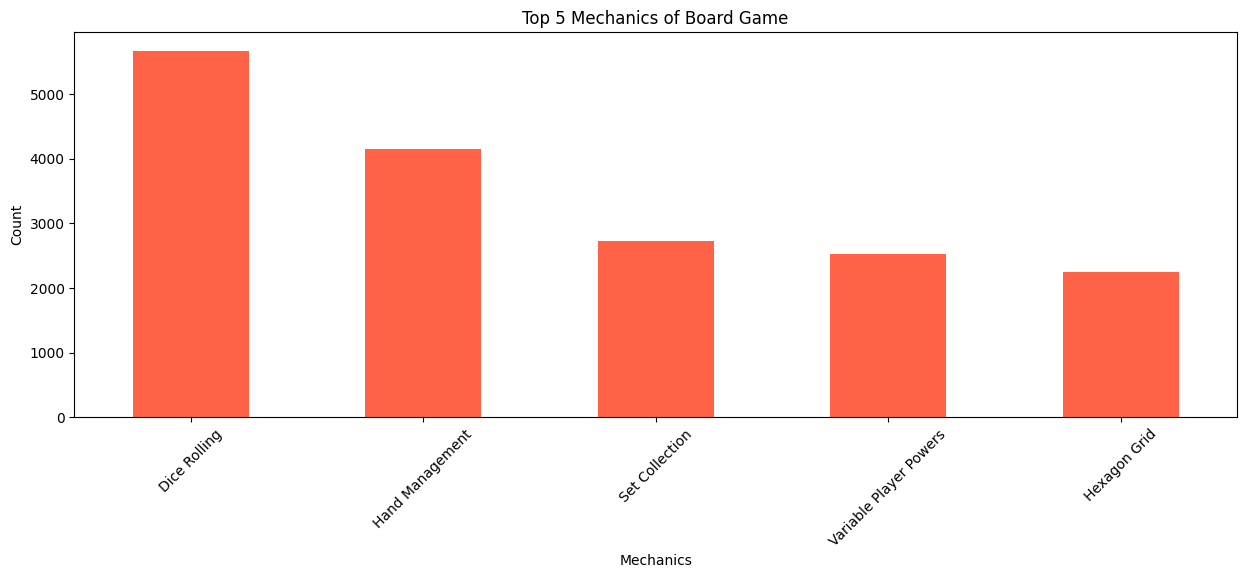

In [148]:
# menunjukkan mekanik teratas menggunakan bar chart
plt.figure(figsize=(15,5))
top_mechanics.plot(kind='bar', color='tomato')
plt.title('Top 5 Mechanics of Board Game')
plt.xlabel('Mechanics')
plt.ylabel('Count')
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

In [149]:
# tampilkan mekanik terbawah
top_mechanics = mechanics_counts.tail()
top_mechanics

Passed Action Token        4
Selection Order Bid        3
Auction: Dutch Priority    3
Auction: Dexterity         3
Auction: English           1
Name: count, dtype: int64

Dice Rolling atau permainan melempar dadu menjadi mekanik yang paling umum digunakan pada suatu permainan papan. Sementara auction atau lelang adalah mekanik yang paling jarang digunakan.

In [150]:
# memisahkan nilai dalam kolom "domains" menjadi daftar terpisah
domains_split = df2.domains.str.split(', ')

# digabungkan menjadi satu daftar
all_domains = [domain for sublist in domains_split for domain in sublist]

# menghitung kemunculan semua domain
domains_counts = pd.Series(all_domains).value_counts()

# tampilkan domain teratas
top_domains = domains_counts.head(20)
top_domains

Not Specified         10136
Wargames               3316
Strategy Games         2205
Family Games           2173
Thematic Games         1174
Abstract Games         1070
Children's Games        849
Party Games             605
Customizable Games      297
Name: count, dtype: int64

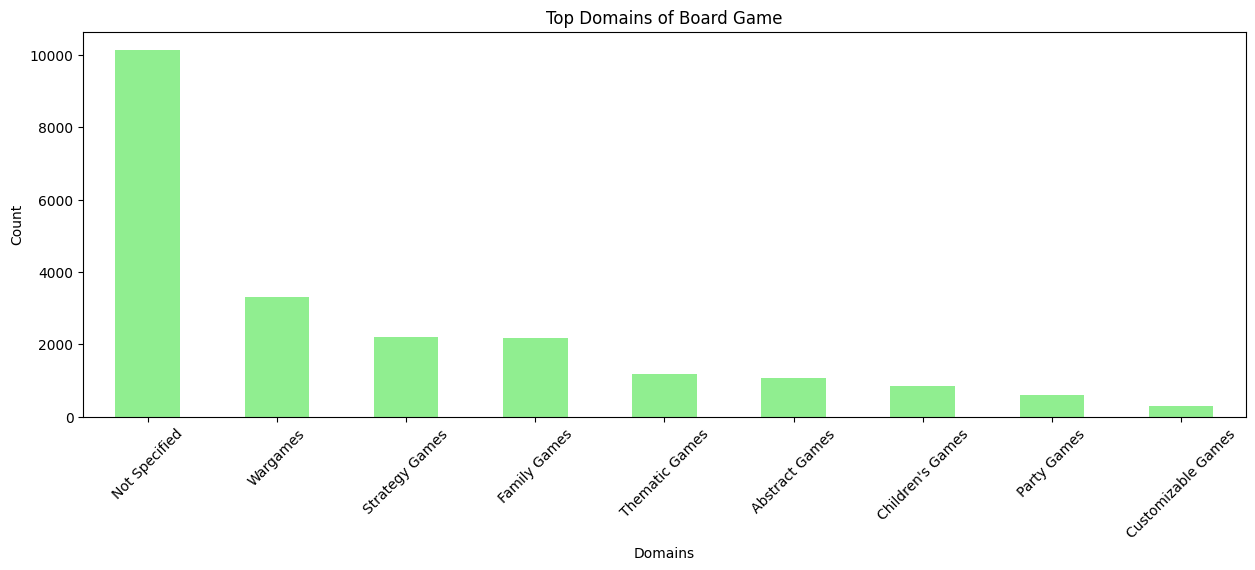

In [151]:
# menunjukkan mekanik teratas menggunakan bar chart
plt.figure(figsize=(15,5))
top_domains.plot(kind='bar', color='lightgreen')
plt.title('Top Domains of Board Game')
plt.xlabel('Domains')
plt.ylabel('Count')
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

Domain atau tipe permainan papan yang paling sering muncul dalam data adalah Wargames atau peperangan, disusul dengan Strategy Games (permainan strategi) dan Family Games (permainan keluarga).

Sedangkan yang paling jarang muncul adalah Customizable Games, dimana pemainnya bebas untuk menentukan sendiri aturan, atribut, ataupun elemen permainannya sebelum permainannya dimulai.

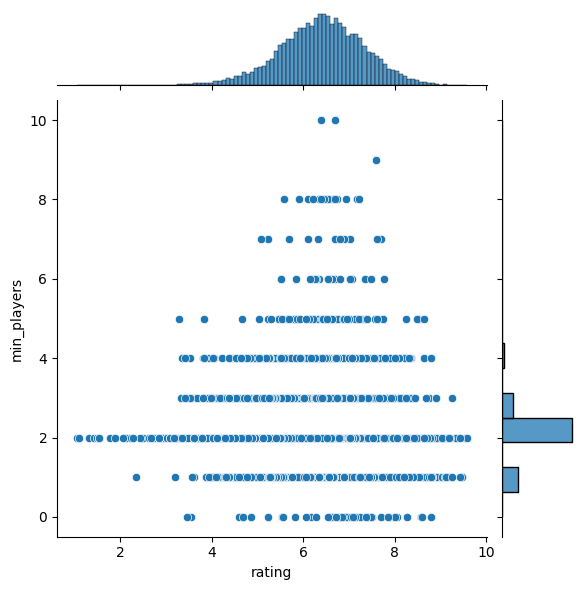

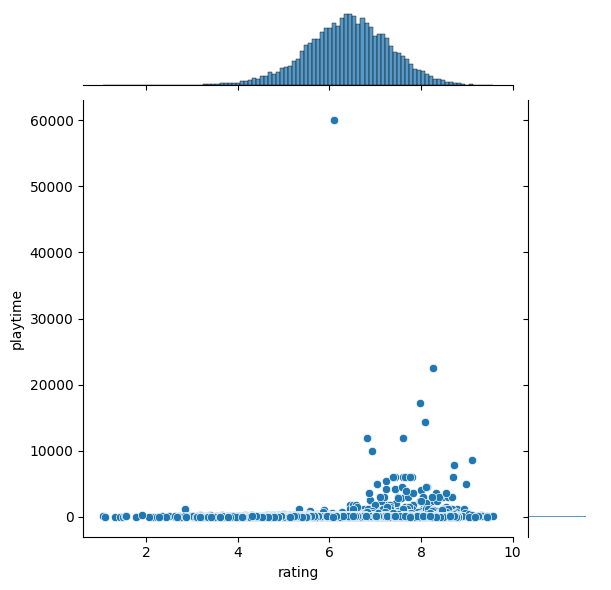

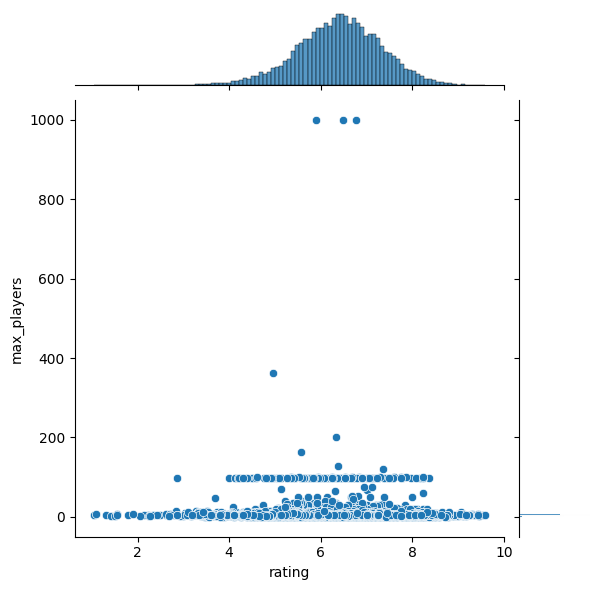

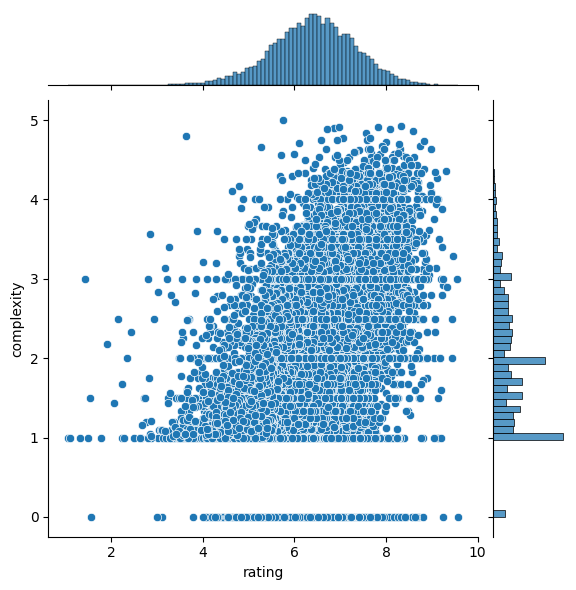

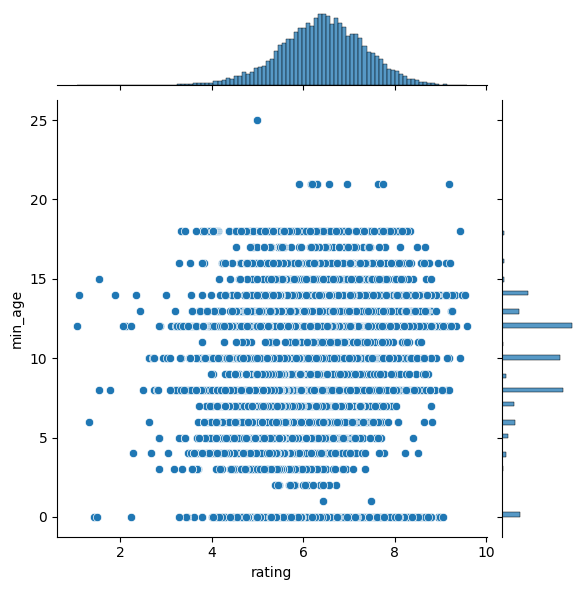

In [153]:
# menunjukkan scatter plot untuk mencari hubungan rating dengan fitur-fitur yang ada
to_plot = ["min_players", "playtime", "max_players", "complexity", "min_age"]
for i in to_plot:
    sns.jointplot(x=df2["rating"], y=df2[i])
    plt.show()

Takeaway:

- Dari grafik kurang bisa terlihat hubungan antara rating dengan fitur-fitur dalam dataset. Namun berdasarkan domain knowledge, seharusnya yang berhubungan erat dengan baik buruknya rating suatu game adalah complexity (tingkat kesulitan) dan juga playtime (waktu untuk menyelesaikan permainan).

## v. Feature Engineering

In [154]:
# copy lagi data asli agar tidak memakai data EDA
df3 = df.copy()

In [155]:
# membagi data menjadi x dan y
x = df3.drop(['rating', 'id', 'name', 'mechanics', 'domains', 'year', 'rank','users_rated'], axis = 1)
y = df3[['rating']]

x

,min_players,max_players,playtime,min_age,complexity,owned_users,top_mechanics,top_domains
0,1,4,120,14,3.86,68323,Action Queue,Strategy Games
1,2,4,60,13,2.84,65294,Action Points,Strategy Games
2,2,4,120,14,3.91,28785,Hand Management,Strategy Games
3,1,5,120,12,3.24,87099,Card Drafting,Strategy Games
4,3,6,480,14,4.22,16831,Action Drafting,Strategy Games
...,...,...,...,...,...,...,...,...
20338,2,2,30,4,1.00,427,Not Specified,Children's Games
20339,2,99,60,5,1.05,1533,Betting and Bluffing,Party Games
20340,2,4,30,3,1.08,5788,Roll / Spin and Move,Children's Games
20341,2,6,30,3,1.02,4400,Dice Rolling,Children's Games


In [156]:
y

,rating
0,8.79
1,8.61
2,8.66
3,8.43
4,8.70
...,...
20338,2.28
20339,2.85
20340,3.18
20341,2.86


In [157]:
# membagi data menjadi train dan test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 14)

In [158]:
# ukuran dari data train dan test
print(f'x_train size: {x_train.shape}')
print(f'y_train size: {y_train.shape}')
print('\n')
print(f'x_test size: {x_test.shape}')
print(f'y_test size: {y_test.shape}')

x_train size: (16256, 8)
y_train size: (16256, 1)


x_test size: (4064, 8)
y_test size: (4064, 1)


In [159]:
# definisikan kolom numerik untuk train
x_train_num = x_train[['min_players',
                       'max_players',
                       'playtime',
                       'min_age',
                       'complexity',
                       'owned_users',



]]
x_train_num

,min_players,max_players,playtime,min_age,complexity,owned_users
6838,2,4,120,12,3.53,195
17744,2,8,60,8,1.50,182
14360,4,15,30,18,1.00,57
5744,2,2,240,12,2.86,651
5077,2,3,240,12,3.56,393
...,...,...,...,...,...,...
12036,3,6,45,8,1.67,334
18858,3,6,60,16,1.50,516
9490,1,1,90,0,3.00,171
13670,2,4,35,9,1.78,313


In [160]:
# definisikan kolom numerik untuk test
x_test_num = x_test[['min_players',
                       'max_players',
                       'playtime',
                       'min_age',
                       'complexity',
                       'owned_users',



]]
x_test_num

,min_players,max_players,playtime,min_age,complexity,owned_users
2167,1,2,120,0,2.85,1809
2720,2,5,90,10,3.56,2521
12031,1,2,0,13,1.50,201
8166,3,6,120,12,2.63,146
16817,2,4,15,7,1.00,218
...,...,...,...,...,...,...
11473,2,6,10,8,1.00,301
17072,2,4,45,8,1.00,140
9457,2,5,50,8,1.25,206
9175,2,2,360,12,3.25,382


In [161]:
# definisikan kolom kategorik untuk train
x_train_cat = x_train[[
    'top_mechanics',
    'top_domains'
]]
x_train_cat

,top_mechanics,top_domains
6838,Area Majority / Influence,Not Specified
17744,Campaign / Battle Card Driven,Wargames
14360,Hand Management,Not Specified
5744,Area-Impulse,Wargames
5077,Action Points,Strategy Games
...,...,...
12036,Action Points,Not Specified
18858,Roll / Spin and Move,Not Specified
9490,Dice Rolling,Wargames
13670,Variable Player Powers,Not Specified


In [162]:
# definisikan kolom kategorik untuk test
x_test_cat = x_test[[
    'top_mechanics',
    'top_domains'
]]
x_test_cat

,top_mechanics,top_domains
2167,Dice Rolling,Thematic Games
2720,Area Majority / Influence,Strategy Games
12031,Deck Bag and Pool Building,Not Specified
8166,Not Specified,Not Specified
16817,Rock-Paper-Scissors,Not Specified
...,...,...
11473,Player Elimination,Not Specified
17072,Modular Board,Children's Games
9457,Area Majority / Influence,Not Specified
9175,Hexagon Grid,Wargames


### Cek Outlier

In [163]:
# cek distribusi data kolom numerik
x_train_num.skew()

min_players     1.832873
max_players    42.135248
playtime       73.676052
min_age        -0.842701
complexity      0.421860
owned_users    12.580559
dtype: float64

### Kolom Kategorikal

In [164]:
# melakukan encoding dengan onehotencoder
ohe = OneHotEncoder(handle_unknown='ignore')

x_train_cat_enc = ohe.fit_transform(x_train_cat[['top_mechanics', 'top_domains']])

x_train_cat_final = pd.DataFrame(x_train_cat_enc.toarray(), index = x_train_cat.index, columns=ohe.get_feature_names_out(['top_mechanics','top_domains']))
x_train_cat_final

,top_mechanics_Acting,top_mechanics_Action Drafting,top_mechanics_Action Points,top_mechanics_Action Queue,top_mechanics_Action Retrieval,top_mechanics_Action Timer,top_mechanics_Action/Event,top_mechanics_Advantage Token,top_mechanics_Alliances,top_mechanics_Area Majority / Influence,...,top_mechanics_Worker Placement,top_domains_Abstract Games,top_domains_Children's Games,top_domains_Customizable Games,top_domains_Family Games,top_domains_Not Specified,top_domains_Party Games,top_domains_Strategy Games,top_domains_Thematic Games,top_domains_Wargames
6838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5077,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12036,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [165]:
# encoding juga untuk data test
x_test_cat_enc = ohe.transform(x_test_cat[['top_mechanics', 'top_domains']])

x_test_cat_final = pd.DataFrame(x_test_cat_enc.toarray(), index = x_test_cat.index, columns=ohe.get_feature_names_out(['top_mechanics','top_domains']))
x_test_cat_final

,top_mechanics_Acting,top_mechanics_Action Drafting,top_mechanics_Action Points,top_mechanics_Action Queue,top_mechanics_Action Retrieval,top_mechanics_Action Timer,top_mechanics_Action/Event,top_mechanics_Advantage Token,top_mechanics_Alliances,top_mechanics_Area Majority / Influence,...,top_mechanics_Worker Placement,top_domains_Abstract Games,top_domains_Children's Games,top_domains_Customizable Games,top_domains_Family Games,top_domains_Not Specified,top_domains_Party Games,top_domains_Strategy Games,top_domains_Thematic Games,top_domains_Wargames
2167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Kolom Numerikal

In [166]:
# standardisasi dengan Robust Scaler karena lebih tahan outlier
scaler = RobustScaler()
x_train_num_scaled = scaler.fit_transform(x_train_num)
x_test_num_scaled  = scaler.transform(x_test_num)

In [167]:
# mengubah bentuk array ke dataframe setelah scaling
x_train_num_final = pd.DataFrame(x_train_num_scaled, columns=x_train_num.columns, index=x_train_num.index)
x_test_num_final = pd.DataFrame(x_test_num_scaled, columns=x_test_num.columns, index=x_test_num.index)

In [168]:
# gabungkan lagi kolom kategorik dan numerik di train 
x_train_final = pd.concat([x_train_cat_final, x_train_num_final], axis=1)
x_train_final

,top_mechanics_Acting,top_mechanics_Action Drafting,top_mechanics_Action Points,top_mechanics_Action Queue,top_mechanics_Action Retrieval,top_mechanics_Action Timer,top_mechanics_Action/Event,top_mechanics_Advantage Token,top_mechanics_Alliances,top_mechanics_Area Majority / Influence,...,top_domains_Party Games,top_domains_Strategy Games,top_domains_Thematic Games,top_domains_Wargames,min_players,max_players,playtime,min_age,complexity,owned_users
6838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.250000,0.50,1.297521,-0.159341
17744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,2.0,0.250000,-0.50,-0.380165,-0.177198
14360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,5.5,-0.250000,2.00,-0.793388,-0.348901
5744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.0,3.250000,0.50,0.743802,0.467033
5077,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-0.5,3.250000,0.50,1.322314,0.112637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12036,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,-0.50,-0.239669,0.031593
18858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.250000,1.50,-0.380165,0.281593
9490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-1.0,-1.5,0.750000,-2.50,0.859504,-0.192308
13670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.166667,-0.25,-0.148760,0.002747


In [169]:
# gabungkan lagi kolom kategorik dan numerik di test 
x_test_final = pd.concat([x_test_cat_final, x_test_num_final], axis=1)
x_test_final

,top_mechanics_Acting,top_mechanics_Action Drafting,top_mechanics_Action Points,top_mechanics_Action Queue,top_mechanics_Action Retrieval,top_mechanics_Action Timer,top_mechanics_Action/Event,top_mechanics_Advantage Token,top_mechanics_Alliances,top_mechanics_Area Majority / Influence,...,top_domains_Party Games,top_domains_Strategy Games,top_domains_Thematic Games,top_domains_Wargames,min_players,max_players,playtime,min_age,complexity,owned_users
2167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-1.0,-1.0,1.250000,-2.50,0.735537,2.057692
2720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.5,0.750000,0.00,1.322314,3.035714
12031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-0.750000,0.75,-0.380165,-0.151099
8166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.250000,0.50,0.553719,-0.226648
16817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.500000,-0.75,-0.793388,-0.127747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.583333,-0.50,-0.793388,-0.013736
17072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.50,-0.793388,-0.234890
9457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.5,0.083333,-0.50,-0.586777,-0.144231
9175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.0,5.250000,0.50,1.066116,0.097527


## vi. Model Definition

In [170]:
# mendefinisikan model-model yang ingin dicoba
linreg = LinearRegression()
knn = KNeighborsRegressor()
svm = SVR()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()
xg = xgb.XGBRegressor()
ada = AdaBoostRegressor()

In [171]:
# mendefinisikan nama-nama kolom numerik dan kategorik
num_col = x_train_num.columns.tolist()
cat_col = x_train_cat.columns.tolist()

print('Numerical Columns : ', num_col)
print('Categorical Columns : ', cat_col)

Numerical Columns :  ['min_players', 'max_players', 'playtime', 'min_age', 'complexity', 'owned_users']
Categorical Columns :  ['top_mechanics', 'top_domains']


### Without Pipeline

Coba cara biasa tanpa pipeline, cara yang dilakukan pada tugas yang lalu.

In [172]:
# model linear regression
linreg = LinearRegression()
linreg.fit(x_train_final, y_train)

LinearRegression()

In [173]:
# menghitung koefisien (slope) dari model
slope = linreg.coef_

# menghitung intercept dari model
intercept = linreg.intercept_

print(f'nilai slope(coefficient):{slope}')
print(f'nilai intercept:{intercept}')

nilai slope(coefficient):[[-8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -8.54947397e+09
  -8.54947397e+09 -8.54947397e+09 -8.54947397e+09 -

In [174]:
# melakukan prediksi pada data test
y_pred_train = linreg.predict(x_train_final)
y_pred_test = linreg.predict(x_test_final)

In [175]:
# menghitung nilai error dari train dan test
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

print('MAE:')
print(f'train: {mae_train}')
print(f'test: {mae_test}')
print('')

MAE:
train: 0.5739227287788091
test: 6311128.024463411



Nilai yang didapatkan sungguh aneh tapi nyata. Kita coba pakai pipeline.

### Pipeline

In [176]:
# num_pipeline = make_pipeline(Winsorizer(capping_method='gaussian',
#         tail='both',
#         fold=1.5),
#         RobustScaler())



# membuat pipeline
num_pipeline = make_pipeline(RobustScaler())

cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

preprocessing_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, num_col),
    ('pipe_cat', cat_pipeline, cat_col)


])

## vii. Model Training

In [177]:
# train pipeline ke semua model
pipe_linreg = make_pipeline(preprocessing_pipeline, linreg)
pipe_knn = make_pipeline(preprocessing_pipeline, knn)
pipe_svm = make_pipeline(preprocessing_pipeline, svm)
pipe_rf = make_pipeline(preprocessing_pipeline, rf)
pipe_dt = make_pipeline(preprocessing_pipeline, dt)
pipe_xg = make_pipeline(preprocessing_pipeline, xg)
pipe_ada = make_pipeline(preprocessing_pipeline, ada)

pipelines = [pipe_linreg, pipe_knn, pipe_svm, pipe_rf, pipe_dt, pipe_xg, pipe_ada]

for pipe in pipelines:
  pipe.fit(x_train, y_train)

C:\Users\JONZ PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JONZ PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\JONZ PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

## viii. Model Evaluation

### Prediction

In [178]:
# membuat prediksi dengan pipeline setelah training
predict_linreg = pipe_linreg.predict(x_test)
predict_knn = pipe_knn.predict(x_test)
predict_svm = pipe_svm.predict(x_test)
predict_rf = pipe_rf.predict(x_test)
predict_dt = pipe_dt.predict(x_test)
predict_xg = pipe_xg.predict(x_test)
predict_ada = pipe_ada.predict(x_test)

### MSE

In [179]:
# tampilkan nilai mean squared error
mse_linreg = mean_squared_error(y_test, predict_linreg)
mse_knn = mean_squared_error(y_test, predict_knn)
mse_svm = mean_squared_error(y_test, predict_svm)
mse_rf = mean_squared_error(y_test, predict_rf)
mse_dt = mean_squared_error(y_test, predict_dt)
mse_xg = mean_squared_error(y_test, predict_xg)
mse_ada = mean_squared_error(y_test, predict_ada)

print(f'MSE:\n')
print(f'Linear Regression: {mse_linreg:.2f}')
print(f'KNN: {mse_knn:.2f}')
print(f'SVM: {mse_svm:.2f}')
print(f'Random Forest: {mse_rf:.2f}')
print(f'Decision Tree: {mse_dt:.2f}')
print(f'XG Boost: {mse_xg:.2f}')
print(f'Ada Boost: {mse_ada:.2f}')
mse_results = [mse_linreg, mse_knn, mse_svm, mse_rf, mse_dt, mse_xg, mse_ada]

MSE:

Linear Regression: 0.59
KNN: 0.62
SVM: 0.56
Random Forest: 0.55
Decision Tree: 1.06
XG Boost: 0.53
Ada Boost: 0.70


### RMSE

In [180]:
# tampilkan nilai root mean squared error
rmse_linreg = root_mean_squared_error(y_test, predict_linreg)
rmse_knn = root_mean_squared_error(y_test, predict_knn)
rmse_svm = root_mean_squared_error(y_test, predict_svm)
rmse_rf = root_mean_squared_error(y_test, predict_rf)
rmse_dt = root_mean_squared_error(y_test, predict_dt)
rmse_xg = root_mean_squared_error(y_test, predict_xg)
rmse_ada = root_mean_squared_error(y_test, predict_ada)

print(f'RMSE:\n')
print(f'Linear Regression: {rmse_linreg:.2f}')
print(f'KNN: {rmse_knn:.2f}')
print(f'SVM: {rmse_svm:.2f}')
print(f'Random Forest: {rmse_rf:.2f}')
print(f'Decision Tree: {rmse_dt:.2f}')
print(f'XG Boost: {rmse_xg:.2f}')
print(f'Ada Boost: {rmse_ada:.2f}')
rmse_results = [rmse_linreg, rmse_knn, rmse_svm, rmse_rf, rmse_dt, rmse_xg, rmse_ada]

RMSE:

Linear Regression: 0.77
KNN: 0.79
SVM: 0.75
Random Forest: 0.74
Decision Tree: 1.03
XG Boost: 0.73
Ada Boost: 0.84


### MAE

In [181]:
# tampilkan nilai mean absolute error
mae_linreg = mean_absolute_error(y_test, predict_linreg)
mae_knn = mean_absolute_error(y_test, predict_knn)
mae_svm = mean_absolute_error(y_test, predict_svm)
mae_rf = mean_absolute_error(y_test, predict_rf)
mae_dt = mean_absolute_error(y_test, predict_dt)
mae_xg = mean_absolute_error(y_test, predict_xg)
mae_ada = mean_absolute_error(y_test, predict_ada)

print(f'MAE:\n')
print(f'Linear Regression: {mae_linreg:.2f}')
print(f'KNN: {mae_knn:.2f}')
print(f'SVM: {mae_svm:.2f}')
print(f'Random Forest: {mae_rf:.2f}')
print(f'Decision Tree: {mae_dt:.2f}')
print(f'XG Boost: {mae_xg:.2f}')
print(f'Ada Boost: {mae_ada:.2f}')
mae_results = [mae_linreg, mae_knn, mae_svm, mae_rf, mae_dt, mae_xg, mae_ada]

MAE:

Linear Regression: 0.58
KNN: 0.60
SVM: 0.57
Random Forest: 0.56
Decision Tree: 0.78
XG Boost: 0.55
Ada Boost: 0.65


### R2 Score

In [182]:
# tampilkan nilai R2
r2_linreg = r2_score(y_test, predict_linreg)
r2_knn = r2_score(y_test, predict_knn)
r2_svm = r2_score(y_test, predict_svm)
r2_rf = r2_score(y_test, predict_rf)
r2_dt = r2_score(y_test, predict_dt)
r2_xg = r2_score(y_test, predict_xg)
r2_ada = r2_score(y_test, predict_ada)


print(f'R2 Score:\n')
print(f'Linear Regression: {r2_linreg:.2f}')
print(f'KNN: {r2_knn:.2f}')
print(f'SVM: {r2_svm:.2f}')
print(f'Random Forest: {r2_rf:.2f}')
print(f'Decision Tree: {r2_dt:.2f}')
print(f'XG Boost: {r2_xg:.2f}')
print(f'Ada Boost: {r2_ada:.2f}')
r2_results = [r2_linreg, r2_knn, r2_svm, r2_rf, r2_dt, r2_xg, r2_ada]

R2 Score:

Linear Regression: 0.32
KNN: 0.28
SVM: 0.35
Random Forest: 0.37
Decision Tree: -0.23
XG Boost: 0.39
Ada Boost: 0.19


### Rangkuman Hasil Evaluasi

In [183]:
# membuat colormap
cmap = colors.ListedColormap(["#615154"])

In [184]:
# menyimpan hasil evaluasi ke dalam dataset
models = ['Linear Regression', 'KNN', 'SVM', 'Random Forest', 'Decision Tree', 'XGBoost', 'AdaBoost']

df_results = pd.DataFrame({
    'Model': models,
    'MAE': mae_results,
    'MSE': mse_results,
    'RMSE': rmse_results,
    'R2 Score': r2_results
})
df_results
df_results.style.background_gradient(cmap=cmap)

,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression,0.584460,0.587456,0.766457,0.320527
1,KNN,0.598692,0.622635,0.789072,0.279837
2,SVM,0.567896,0.563967,0.750977,0.347695
3,Random Forest,0.558138,0.546290,0.739114,0.368141
4,Decision Tree,0.775743,1.060972,1.030035,-0.227160
5,XGBoost,0.547239,0.527925,0.726585,0.389382
6,AdaBoost,0.652761,0.698768,0.835923,0.191779


Terlihat bahwa model XGBoost memiliki MAE, MSE, dan RMSE paling rendah serta R2 Score paling tinggi, maka untuk sekarang saya akan menggunakan model tersebut.

### Cross Validation

In [185]:
# cross validation untuk model linear regression
cross_val_linreg = cross_val_score(pipe_linreg,
                            x_train,
                            y_train,
                            cv=3,
                            scoring="neg_mean_squared_error")
print(cross_val_linreg.mean())
print(cross_val_linreg.std())

-0.5941257601083666
0.015427848513362213


In [186]:
# cross validation untuk model SVM
cross_val_svm = cross_val_score(pipe_svm,
                            x_train,
                            y_train,
                            cv=3,
                            scoring="neg_mean_squared_error")
print(cross_val_svm.mean())
print(cross_val_svm.std())

C:\Users\JONZ PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JONZ PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\JONZ PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

-0.5730946005725575
0.021087819238719895


In [187]:
# cross validation untuk model KNN
cross_val_knn = cross_val_score(pipe_knn,
                            x_train,
                            y_train,
                            cv=3,
                            scoring="neg_mean_squared_error")
print(cross_val_knn.mean())
print(cross_val_knn.std())

-0.6215090295698161
0.012993887220762878


In [188]:
# cross validation untuk model Random Forest
cross_val_rf = cross_val_score(pipe_rf,
                            x_train,
                            y_train,
                            cv=3,
                            scoring="neg_mean_squared_error")
print(cross_val_rf.mean())
print(cross_val_rf.std())

C:\Users\JONZ PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\JONZ PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\JONZ PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

-0.5575853029996275
0.018941313826426887


In [189]:
# cross validation untuk model XGBoost
cross_val_xg = cross_val_score(pipe_xg,
                            x_train,
                            y_train,
                            cv=3,
                            scoring="neg_mean_squared_error")
print(cross_val_xg.mean())
print(cross_val_xg.std())

-0.5441054469542275
0.011775881458088642


Setelah melakukan cross validation juga ditemukan nilai standar deviasi dari XGB paling kecil, maka model tersebut akan diambil untuk dilakukan Hyperparameter Tuning.

### Hyperparameter Tuning

In [190]:
# tentukan grid parameter
param_grid = {
    'xgbregressor__learning_rate': [0.05, 0.1, 0.2],
    'xgbregressor__n_estimators': [100, 200, 300],
    'xgbregressor__max_depth': [3, 5, 7],
    'xgbregressor__min_child_weight': [1, 3, 5],
    'xgbregressor__gamma': [0, 0.1, 0.2]
}

# membuat objek GridSearchCV
grid_search = GridSearchCV(estimator=pipe_xg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# melakukan hyperparameter tuning pada data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipe_num',
                                                                         Pipeline(steps=[('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['min_players',
                                                                          'max_players',
                                                                          'playtime',
                                                                          'min_age',
                                                                          'complexity',
                                                                          'owned_users']),
                                                                        ('pipe_cat',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['top_mechanics',
                                                                          'top_dom...
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgbregressor__gamma': [0, 0.1, 0.2],
                         'xgbregressor__learning_rate': [0.05, 0.1, 0.2],
                         'xgbregressor__max_depth': [3, 5, 7],
                         'xgbregressor__min_child_weight': [1, 3, 5],
                         'xgbregressor__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [191]:
# menampilkan parameter terbaik
best_params = grid_search.best_params_
tabel_best_params = pd.DataFrame(best_params.items(), columns=['Parameters','Value'])
tabel_best_params

,Parameters,Value
0,xgbregressor__gamma,0.2
1,xgbregressor__learning_rate,0.1
2,xgbregressor__max_depth,5.0
3,xgbregressor__min_child_weight,5.0
4,xgbregressor__n_estimators,200.0


In [192]:
# menampilkan nilai MSE setelah pemodelan dengan parameter terbaik
best_score_mse = -grid_search.best_score_
print(f'Nilai MSE setelah tuning: {best_score_mse:.3f}')

Nilai MSE setelah tuning: 0.523


## ix. Model Saving

In [193]:
# melakukan fit untuk kebutuhan model inference
pipe_xg_1 = pipe_xg.fit(x_train, y_train)

In [194]:
# menyimpan semua yang dibutuhkan untuk inference
with open('list_num_cols.txt', 'w') as file_1:
  json.dump(num_col, file_1)

with open('list_cat_cols.txt', 'w') as file_2:
  json.dump(cat_col, file_2)

with open('num_pipeline.pkl', 'wb') as file_3:
  pickle.dump(num_pipeline, file_3)

with open('cat_pipeline.pkl', 'wb') as file_4:
  pickle.dump(cat_pipeline, file_4)

with open('preprocessing.pkl', 'wb') as file_5:
  pickle.dump(preprocessing_pipeline, file_5)

with open('xgboost.pkl', 'wb') as file_6:
  pickle.dump(xg, file_6)

with open('pipe_xg_1.pkl', 'wb') as file_7:
  pickle.dump(pipe_xg_1, file_7)

## x. Model Inference

Klik di [sini](P1M2_ferrasta_veron_inf.ipynb) untuk ke notebook inference.


## xi. Pengambilan Kesimpulan

### Conceptual Problems

- **Latar belakang dan cara kerja Bagging**

    Bagging merupakan salah satu dari Ensemble Learning, yang konsepnya adalah menggabungkan individual model untuk menghasilkan model yang lebih baik, lebih robust, lebih akurat. 
    Bagging sendiri adalah penggabungan dari Bootstrap dan Aggregation. Nantinya data asli akan dibagi dan dilatih dengan model yang berbeda-beda. Untuk pemodelan regresi, diambil rata-rata model tersebut untuk model terbaiknya, sedangkan pemodelan klasifikasi, akan digunakan voting model terbaik mana yang akan dipilih. 

    Jadi adanya bagging itu untuk mencari model terbaik tapi bukan hanya dari satu model melainkan model-model lain, agar menghindari overfitting dan didapatkan model yang benar-benar terbaik dari yang terbaik.

- **Perbedaan algoritma Random Forest dan algoritma yang saya pilih, XGBoost**

    Random Forest adalah algoritma Bagging, sedangkan XGBoost adalah algoritma Boosting. Perbedaan mendasarnya adalah kalau bagging melatih modelnya sendiri-sendiri dan mengambil sampel secara acak, boosting melatih modelnya secara sequential, yang artinya modelnya tetap sama hanya dilakukan perbaikan terus-menerus. 
    
- **Penjelasan Cross Validation**

    Teknik evaluasi model untuk mengukur kinerja secara objektif pada data baru. Nantinya data train akan dibagi lagi menjadi beberapa folds atau lipatan, biasanya di antara 5-10. Diambil satu folds untuk validation dan sisanya untuk latihan model. Nah setelah itu akan diulang untuk folds lainnya sampai folds terakhir, hasil akhirnya merupakan rata-rata dari semua validation untuk menunjukkan performa model kita sudah baik atau belum. 
    

### Kesimpulan

In [195]:
# rangkuman evaluasi
models = ['Linear Regression', 'KNN', 'SVM', 'Random Forest', 'Decision Tree', 'XGBoost', 'AdaBoost']

df_results = pd.DataFrame({
    'Model': models,
    'MAE': mae_results,
    'MSE': mse_results,
    'RMSE': rmse_results,
    'R2 Score': r2_results
})
df_results
df_results.style.background_gradient(cmap=cmap)

,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression,0.584460,0.587456,0.766457,0.320527
1,KNN,0.598692,0.622635,0.789072,0.279837
2,SVM,0.567896,0.563967,0.750977,0.347695
3,Random Forest,0.558138,0.546290,0.739114,0.368141
4,Decision Tree,0.775743,1.060972,1.030035,-0.227160
5,XGBoost,0.547239,0.527925,0.726585,0.389382
6,AdaBoost,0.652761,0.698768,0.835923,0.191779


Setelah melalui proses pemodelan untuk mencari model yang dapat memprediksi rating suatu Board Game, telah didapatkan model dengan XGBoost.

XGBoost menjadi model terpilih karena memiliki nilai error paling rendah dan juga memiliki nilai R2 Score paling tinggi. Walaupun nilai errornya masih terbilang cukup besar di 0.52 (MSE) dan R2 Score yang hanya di 0.389, model ini masih yang terbaik apabila dibandingkan dengan model-model lainnya.

Untuk meningkatkan kinerja model mungkin bisa menggunakan semua data kategorikal seperti Mechanics dan Domains yang belum dikurangi jumlahnya, karena sebenarnya satu permainan itu bisa memiliki lebih dari satu mekanik maupun domain. Namun pada model ini saya hanya mengambil masing-masing satu mekanik dan domain agar memudahkan ketika melakukan inference data baru dan model deployment di aplikasi web.